# COGS 108 - Final Project 

# Overview

My project attempted determine if parks in high-crime areas received lower Yelp ratings than parks in lower-crime areas, using the amount of police calls as a proxy for crime rate. For each park in the Yelp dataset, I counted the number of police calls within a half mile of the park. No significant relationship was found between the crime rate of a park's neighborhood and the average Yelp rating.

# Name & GitHub

- Name: Hayden Syzdek
- GitHub Username: hsyzdek

# Research Question

Does the crime rate of a park's neighborhood negatively influence it's Yelp rating?

## Background and Prior Work

Yelp is a website where users can rate places they have visited and view others' ratings<sup>1</sup>.

The City of San Diego, the state and federal government, and private entities own and operate many parks throughout the city. Studies have shown that access to parks has a variety of physical, emotional, and enviromental perks<sup>2</sup>. The San Diego Parks and Recreation Department periodically seeks resident feedback to inform their direction<sup>3</sup>. If people have bias against parks in areas with high crime, the data collected from surveys could cause resources to be diverted away from those parks, hurting those who live in high-crime communities.

References (include links):
- 1) About Yelp retrieved from https://www.yelp.com/about
- 2) The Health Benefits of Parks retrieved from http://usahomepagewww.eastshorepark.org/HealthBenefitsReport_FINAL_010307.pdf
- 3) Complete Our Needs Assessment Survey
 https://www.sdparks.org/content/sdparks/en/news-events/news-stories/2020NeedsAssessmentSurvey.html.html

# Hypothesis


I hypothesize that as a park's neighborhood recieves more police calls, the rating of the park will decrease.

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: San Diego Crime Data (2019)
- Link to the dataset: https://data.sandiego.gov/datasets/police-calls-for-service/
- Number of observations: 590967 (We randomly sample 15,000)
- Description: This database has a record of every police call. It records many features including the date, type of call, and priority. The only feature I use is the address of the call.

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://www.yelp.com/
- Number of observations: 833
- Description: This dataset provides the rating, location, and general information for parks in San Diego

I combine these datasets on location. Using Google's Geocoding API, I convert the address of the police call into latitude and longitude.

# Setup

In [124]:
## YOUR CODE HERE
import geopandas
import geopy
import pandas as pd
import geocoder
import numpy as np
import threading
import concurrent.futures
import geopy.distance
import folium
from folium import plugins
import branca.colormap
import branca
from collections import defaultdict
import math
import patsy
import statsmodels.api as sm
import seaborn as sns


In [2]:
parks = pd.read_csv("../data/yelp_SD_parks.csv")
crimes = pd.read_csv("../data/pd_calls_for_service_2019_datasd.csv")

In [3]:
crimes

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E19010000001,2019-01-01 00:00:01,1,3800,NaN,NATIONAL,AVE,NaN,NaN,NaN,AU1,DUP,441,1
1,E19010000002,2019-01-01 00:00:04,1,6500,NaN,REFLECTION,DR,NaN,NaN,NaN,415,K,321,2
2,E19010000003,2019-01-01 00:00:09,1,0,NaN,06TH,AVE,NaN,ISLAND,NaN,FD,K,523,2
3,E19010000004,2019-01-01 00:00:19,1,0,NaN,VESTA,ST,NaN,MAIN,NaN,AU1,W,511,1
4,E19010000005,2019-01-01 00:00:31,1,0,NaN,04TH,AVE,NaN,ISLAND,NaN,586,CAN,523,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590962,E19120050370,2019-12-31 23:57:36,3,4300,NaN,OCEAN,BLV,NaN,NaN,NaN,FOOT,CAN,122,3
590963,E19120050372,2019-12-31 23:58:11,3,3400,NaN,RUFFIN,RD,NaN,NaN,NaN,415N,K,311,3
590964,E19120050373,2019-12-31 23:59:30,3,0,NaN,04TH,AVE,NaN,K,NaN,1016,A,-1,2
590965,E19120050374,2019-12-31 23:59:35,3,0,NaN,04TH,AVE,NaN,K,NaN,1016,A,523,2


In [4]:
parks

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.619239e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.619233e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False
...,...,...,...,...,...,...,...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",1.619287e+10,ggbc59hSsl6pxCGSN1QLQA,https://www.yelp.com/biz/del-cerro-san-diego-s...,4.5,12,-117.073524,32.792626,False
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",1.619238e+10,c8jhIMcwSjWqBD7S-faKYg,https://www.yelp.com/biz/san-diego-metropolita...,2.5,268,-117.153400,32.705760,False
830,Petco Park,"100 Park Blvd San Diego, CA 92101",1.619796e+10,HkgSbRLVMRHExsRkImIK5A,https://www.yelp.com/biz/petco-park-san-diego?...,4.0,1667,-117.157054,32.707246,False
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",1.760434e+10,wYGJ65iVMi74-3TylWxY0Q,https://www.yelp.com/biz/ann-d-l-heureux-memor...,3.0,50,-117.316419,33.171137,False


In [5]:
#Google API Key. Removed my own because I'm pushing to github,
#insert your own or contact me if you want to run the code
GOOGLE_API_KEY = None

# Data Cleaning

Describe your data cleaning steps here.

In [7]:
#Convert row into address string
def parseAddress(row):
    out = ""
    if str(row["address_number_primary"]) != "0":
        out += str(row["address_number_primary"]) + " "
        x = str(row["address_road_primary"])
        if x[0] == "0":
            x = x[1:]
        out += x
        if str(row["address_sfx_primary"]) != 'nan':
            out += " " + row["address_sfx_primary"]
    elif str(row["address_road_intersecting"]) != "nan":
        x = str(row["address_road_primary"])
        if x[0] == "0":
            x = x[1:]
        out += x
        if str(row["address_sfx_primary"]) != 'nan':
            out += " " +row["address_sfx_primary"]
        out += " AND "
        x = str(row["address_road_intersecting"])
        if x[0] == "0":
            x = x[1:]
        out += x
        if str(row["address_sfx_intersecting"]) != 'nan':
            out += " " + row["address_sfx_intersecting"]
    else:
        return np.nan
    return out + ", San Diego, CA"

In [8]:
#Convert street address to long/lat
def doIt(row):
    s = parseAddress(row)
    if s == np.nan:
        res = np.nan
    else:
        res = geocoder.google(s, key = GOOGLE_API_KEY, rate_limit = False)
    return (row["incident_num"], res)

In [9]:
#Due to API and hardware limitations, we randomly sample 15,000 police calls
#from the database
with concurrent.futures.ThreadPoolExecutor(50) as executor:
    result = executor.map(doIt, [row for _, row in crimes.sample(n=15000).iterrows()])

In [12]:
#Create a file with the geoencoded data so we don't have to make the API calls
#every time
results2 = "id, long, lat"
lc = 0
for i, r in result:
    if r == np.nan or r.json is None:
        continue
    else:
        lc += 1
        results2 += "\n" + str(i) + ", " + str(r.json["lng"]) + ", " + str(r.json["lat"])

In [14]:
with open('crimeLocs.csv', mode='wt', encoding='utf-8') as myfile:
    myfile.write(results2)

In [27]:
cdf = pd.read_csv('crimeLocs.csv')
cdf.columns = ['id', 'long', 'lat']
cdf

,id,long,lat
0,E19050034688,-117.240912,32.749481
1,E19080031855,-117.048716,32.676447
2,E19040043725,-117.249672,32.851449
3,E19080029013,-117.152641,32.884444
4,E19030052941,-117.076093,32.725233
...,...,...,...
8903,E19030020300,-117.149272,32.704959
8904,E19070009835,-117.137991,32.769081
8905,E19020003875,-117.085027,32.717423
8906,E19110009589,-117.130193,32.755406


In [42]:
#Drop unecessary columns
pdf = parks[['name', 'longitude', 'latitude', 'rating']]
pdf['calls'] = [0] * len(parks['name'])
pdf = pdf.dropna()
pdf

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,longitude,latitude,rating,calls
0,Balboa Park,-117.153150,32.734502,5.0,0
1,Civita Park,-117.147278,32.778315,4.5,0
2,Waterfront Park,-117.172479,32.721952,4.5,0
3,Trolley Barn Park,-117.143789,32.762463,4.5,0
4,Bay View Park,-117.178967,32.701785,5.0,0
...,...,...,...,...,...
828,Del Cerro - San Diego,-117.073524,32.792626,4.5,0
829,San Diego Metropolitan Transit System,-117.153400,32.705760,2.5,0
830,Petco Park,-117.157054,32.707246,4.0,0
831,Ann D. L'Heureux Memorial Dog Park,-117.316419,33.171137,3.0,0


In [141]:
#Count the number of police calls near each park
for i, park in pdf.iterrows():
    pc = (park['latitude'], park['longitude'])
    count = 0
    for _, call in cdf.iterrows():
        cc = (call['lat'], call['long'])
        if geopy.distance.distance(pc, cc).miles < .5:
            count += 1
    pdf.loc[i, 'calls'] = count

In [46]:
pdf.to_csv('parks_calls.csv')

In [144]:
#We toss any park with less than 5 nearby calls, as they might be out of 
#the SD police jurisdiction
pdf = pd.read_csv('parks_calls.csv')
pdf = pdf[pdf['calls'] > 4]

# Data Analysis & Results

# Data visualization
First, let's plot the police calls to ensure that the data is not evenly distributed

In [131]:
#Visualize police calls as a heatmap
parkLocs = [(lat, long) for long, lat in zip(pdf['longitude'], pdf['latitude'])]
xAvg = sum([l[0] for l in parkLocs])/len(parkLocs)
yAvg = sum([l[1] for l in parkLocs])/len(parkLocs)
m = folium.Map([xAvg, yAvg], tiles='Stamen Toner', zoom_start = 11)

loc = 'San Diego Police Calls'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
m.get_root().html.add_child(folium.Element(title_html))

plugins.HeatMap(parkLocs).add_to(m)
m


As seen above, there are pockets of higher police activity, particularly in downtown and on campus, and areas of lower police calls, particularly in areas with low housing density. 

Now, let's make sure there are parks in all areas

In [143]:
#Re-visualise the heatmap with some parks and their ratings.
m = folium.Map([xAvg, yAvg], tiles='Stamen Toner', zoom_start = 11)

loc = 'San Diego Police Calls with Park Ratings'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
m.get_root().html.add_child(folium.Element(title_html))

plugins.HeatMap(parkLocs).add_to(m)

for _, row in pdf.sample(n=20, random_state=1).iterrows():
    lat = row['latitude']
    long = row['longitude']
    name = row['name']
    rating = row['rating']
    folium.Circle([lat, long], radius=500, fill=True).add_child(folium.Popup(name + '\nRating: '+str(rating))).add_to(m)
m

We seem to have parks in areas with both high and low police activity. A cursory analysis does not seem to support the hypothesis of low police calls being correlated with high Yelp reviews - one of the lowest reviews comes from the eastern edge of the map on El Cajon Boulevard. Let's create a scatterplot to look into this in more detail. First, let's take a look at the distribution of our data.

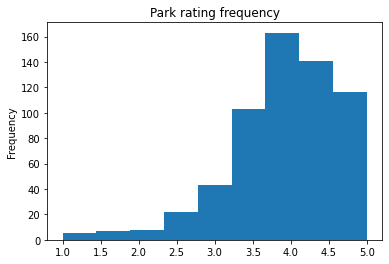

In [101]:
pdf['rating'].plot.hist(bins = 9, title="Park rating frequency")

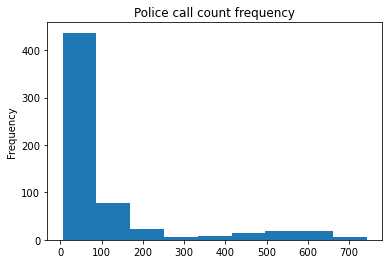

In [110]:
pdf['calls'].plot.hist(bins = 9, title="Police call count frequency")

The park ratings are slightly left skewed, however the police call frequency for each park is very right skewed. We will perform a log-transformation on police calls to help normalize the data.

In [116]:
pdf['log_calls'] = pdf['calls'].apply(math.log)

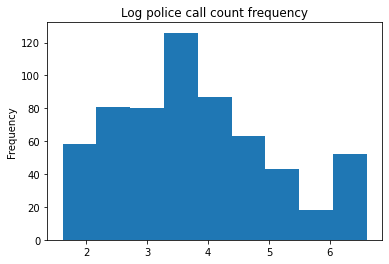

In [117]:
pdf['log_calls'].plot.hist(bins = 9, title="Log police call count frequency")

Now that our police calls are more normalized, let's create a scatterplot to compare the amount of police calls in a park's neighborhood with it's rating.

Text(0.5, 0.98, 'Transformed police calls vs. park rating')

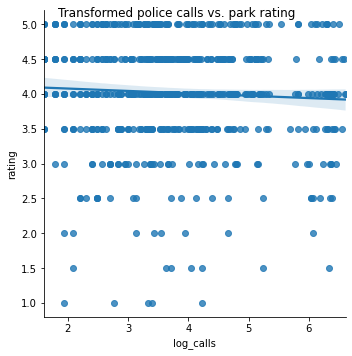

In [129]:
sns.lmplot(x='log_calls',y='rating',data=pdf,fit_reg=True).fig.suptitle("Transformed police calls vs. park rating") 


The scatterplot does not appear to show any correlation between police calls and park ratings. The trendline is slightly negative, however it does not appear to be significant. To verify this, let's get all our linear regression statistics.

# Results

In [142]:
#Perform Ordinary Least Squares on the data
outcome, predictors = patsy.dmatrices('log_calls ~ rating', pdf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_calls   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.794
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.181
Time:                        00:06:10   Log-Likelihood:                -1008.5
No. Observations:                 608   AIC:                             2021.
Df Residuals:                     606   BIC:                             2030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1273      0.264     15.630      0.0

Our adjusted R-squared is 0.001, which is practically no effect. Interestingly, our F-statistic probability is .181, which does not reach significance, but indicates a better-controlled experiment might be able to reach significance. Regardless, it does not appear that police calls in the vicinity of a park negatively influence the park's Yelp rating.

# Ethics & Privacy

The two datasets I used did not have any personally identifiable information. I only used the average rating for each park, meaning I did not deal with any individuals. The parks themselves are ran by public orginizations. The crime data has been pre-cleaned, removing crimes of personal nature and abstracting locations to the block level. There are therefore no privacy concerns.

Ethically, the datasets are allowed to be used for this purpose. There is likely bias in the police call records, as some communities feel less comfortable contacting police. Therefore some areas likely have deflated crime statistics, and some have inflated crime statistics, potentially skewing the results. Bias in Yelp reviews unrelated to crime statistics should cancel out over the hundreds of parks. 

There is a possibility of the analysis being misused. My analysis did not find a relationship between crime rates and Yelp reviews, so it is possible for someone to incorrectly use the analysis as evidence that Yelp reviews are unbiased.

# Conclusion & Discussion

My analysis failed to find any significant influence on a park's Yelp rating based on how many police calls were made in the vicinity of the park. 

There are a number of areas that the analysis might have been improved, however. First, the analysis did not take into account the population density of the park's neighborhood. A park in the city's outskirts will naturally have a lower crime rate. Another possible improvement would be categorizing parks before the analysis, so only like-for-like parks are compared. In my current analysis, Petco Park, home of the San Diego Padres, is compared to Centrum Park, a typical neighborhood park. These parks are likely rated on entirely different criteria. Another possible improvement would be refining the way police calls are counted for each park. My analysis arbitrarily decides any police call within half a mile of the park should count towards the park, however more sophisticated methods may provide more insight.

